In [1]:
import pandas as pd
import geopandas as gpd
import shapely
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from geoalchemy2 import Geometry, WKTElement
import  sqlalchemy 
from scipy.optimize import lsq_linear
from shapely.geometry import MultiLineString
from sqlalchemy.dialects.postgresql import ARRAY, INTEGER, DOUBLE_PRECISION
import time

pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

pg = open('db_credentials.txt')
db = pg.read()
pg.close()
engine = sqlalchemy.create_engine(db)

LIST OF VALUES
VALUE 1
Roadway Type
DESCRIPTION Street
VALUE 2
DESCRIPTION Highway
VALUE 3
DESCRIPTION Bridge
VALUE 4
DESCRIPTION Tunnel
VALUE 5
DESCRIPTION Boardwalk
VALUE 6
DESCRIPTION Path/Trail
VALUE 7
DESCRIPTION Step Street
VALUE 8
DESCRIPTION Driveway
VALUE 9
DESCRIPTION Ramp
VALUE 10
DESCRIPTION Alley
VALUE 11
DESCRIPTION Unknown
VALUE 12
DESCRIPTION Non-Physical Street Segment
VALUE 13
DESCRIPTION U-Turn
VALUE 14
DESCRIPTION Ferry Route

VALUE 0
DESCRIPTION Street other than vehicle only street.
VALUE 1
DESCRIPTION Railroad
VALUE 2
DESCRIPTION Water Edge / Shoreline
VALUE 3
DESCRIPTION Census Block Boundary
VALUE 5
DESCRIPTION Paper Street: This is a legally mapped, but unbuilt street. Such streets are
common in areas of Staten Island anticipating development. May exist in all boroughs.
VALUE 6
DESCRIPTION Private Street: This is a physically existing street which is not owned by the
City and is not officially mapped. For example, streets in the Fort Totten and Breezy Point
sections of Queens.
VALUE 7
DESCRIPTION District Boundary: Physically non-existent boundary for a community district, a
police precinct, or a fire company.
VALUE 8
DESCRIPTION Physical Non-Street Boundary: Physically existing un-addressable boundary
(such as a rock wall cemetery edge).
VALUE 9
DESCRIPTION Paper Street and Census/District Boundary: A legally mapped, but unbuilt
street that also acts as a census block or district boundary.
VALUE A
DESCRIPTION Alley: a narrow street or passageway between and behind city buildings.
VALUE W
DESCRIPTION Path, Non-Vehicular, Addressable: This is a walking path that contains
addresses. For example, some boardwalks and some walking paths in housing projects.
VALUE C
DESCRIPTION CCO (Corporation Counsel Opinion). A CCO is an opinion by the City's Law
Department that a street area, not owned by the City, has been dedicated for public use,
consistent with the requirements of General City Law, Section 36(2). That allows the City to
use public funds for various improvements and services, including paving of the roadway
and installing sewers. The request usually relates to planned work by the City's Department
of Transportation, Department of Design and Construction, and Department of
Environmental Protection.
VALUE F
DESCRIPTION Ferry Route: A schematic representation of a ferry’s passage through a water
body. Please note that only selected ferry routes required for the bicycle routing within NYC
are included.

SEGTYPE
VALUE B
DESCRIPTION Both: Segment is both generic and roadbed; the center roadbed segment of a
divided roadway containing an odd number of roadbeds.
VALUE C
DESCRIPTION Connector: Segments used to connect adjacent roadbeds of a divided street.
Typically these exist to allow traffic flow from one roadbed to another.
VALUE E
DESCRIPTION Entrance/Exit Ramp: Connects a highway to a different street or highway.
VALUE F
DESCRIPTION Faux Segment: These are used when a street or ramp physically ends at a
roadbed, but connectivity needs to be maintained with the generic segment.
VALUE G
DESCRIPTION Generic Segment: An imaginary single line representation of a physically
divided street.
VALUE R
DESCRIPTION Roadbed Segment: Depicts physically separated carriageway segments of a
particular street.
VALUE T
DESCRIPTION Terminator: Used to model situations where a divided section of a street
terminates, but the street itself continues.
VALUE U
DESCRIPTION Undivided Street: All other LION segments that do not fall into any of the
above categories.
VALUE S
DESCRIPTION Suppressed: Undivided segment to be suppressed in a generic view of LION

In [2]:
# lion, segmenttyp != G, 
# rw_type != 6, empty, 7, 8, 12, 14, 11, 10

taxis_query="""
SELECT * FROM taxis_2015_man
WHERE hour_pickup >= 7 AND hour_pickup < 9
AND hour_dropoff >= 7 AND hour_dropoff < 9
"""

lion_clipped = gpd.read_postgis("SELECT * FROM lion WHERE lboro = 1", engine, geom_col='shape')
taxis_clipped = gpd.read_postgis(taxis_query, engine, geom_col='pickup_point')
nodes_clipped = gpd.read_postgis('SELECT * FROM node_man', engine, geom_col='shape')

In [3]:
lion_clipped.head()

,objectid,street,safstreetname,featuretyp,segmenttyp,incexflag,rb_layer,nonped,trafdir,trafsrc,specaddr,facecode,seqnum,streetcode,safstreetcode,lgc1,lgc2,lgc3,lgc4,lgc5,lgc6,lgc7,lgc8,lgc9,boe_lgc,segmentid,segcount,locstatus,lzip,rzip,lboro,rboro,l_cd,r_cd,latomicpolygon,ratomicpolygon,lct2010,lct2010suf,rct2010,rct2010suf,lcb2010,lcb2010suf,rcb2010,rcb2010suf,lct2000,lct2000suf,rct2000,rct2000suf,lcb2000,lcb2000suf,rcb2000,rcb2000suf,lct1990,lct1990suf,rct1990,rct1990suf,lassmdist,lelectdist,rassmdist,relectdist,splitelect,lschldist,rschldist,splitschl,lsubsect,rsubsect,sandistind,mapfrom,mapto,borobndry,mh_ri_flag,xfrom,yfrom,xto,yto,arccenterx,arccentery,curveflag,radius,nodeidfrom,nodeidto,nodelevelf,nodelevelt,conparity,twisted,rw_type,physicalid,genericid,nypdid,fdnyid,lblockfaceid,rblockfaceid,legacyid,status,streetwidth_min,streetwidth_max,streetwidth_irr,bikelane,bike_trafdir,active_flag,posted_speed,snow_priority,number_travel_lanes,number_park_lanes,number_total_lanes,carto_display_level,fcc,row_type,llo_hyphen,lhi_hyphen,rlo_hyphen,rhi_hyphen,fromleft,toleft,fromright,toright,join_id,shape_length,shape
0,87351,BATTERY PARK CITY GREENWAY,,0,U,E,N,D,P,DCP,,0139,02225,100102,,01,,,,,,,,,1,0018067,1,,10280,10280,1,1.0,101,101,921,949,317,04,317,04,4004,,4001,,317,01,317,01,9023,,9022,,319,,317,01,65,013,65,013,,None,02,None,,,,12B,12B,,,979011,196844,979120,196810,0,0,,0,0012339,0012375,M,M,,,6,131896.0,119080.0,,,,,0018067,2,NaN,NaN,,1,TW,None,,,,,,None,,,None,None,None,None,0,0,0,0,1013901000000,114.031859,"MULTILINESTRING ((979011.441 196843.914, 97912..."
1,87352,BATTERY PLACE,,0,U,,B,,T,DOT,,0635,00220,112670,,01,,,,,,,,,1,0018123,2,,10280,10280,1,1.0,101,101,949,914,317,04,317,04,4001,,4005,,317,01,317,01,9022,,9027,,317,01,317,01,65,013,65,012,,02,02,None,1A,1A,,12B,12B,,,979279,196556,979377,196798,980048,196383,L,788,0012377,0012380,M,M,,,1,3.0,3.0,,,0212262587,1222601917,0018123,2,42.0,44.0,,,,None,25,C,2,2,4,None,,,50,64,51,63,50,64,51,63,1063501000000,262.777812,"MULTILINESTRING ((979278.645 196555.536, 97929..."
2,87353,BATTERY PLACE,PS 94,0,U,,B,,T,DOT,N,0635,00220,112670,100011,01,,,,,,,,,1,0018123,2,,10280,10280,1,1.0,101,101,949,914,317,04,317,04,4001,,4005,,317,01,317,01,9022,,9027,,317,01,317,01,65,013,65,012,,02,02,None,1A,1A,,12B,12B,,,979279,196556,979377,196798,980048,196383,L,788,0012377,0012380,M,M,,,1,3.0,3.0,,,0212262587,1222601917,0018123,2,42.0,44.0,,,,None,25,C,2,2,4,None,,,None,None,None,None,0,0,0,0,10001101000000N,262.777812,"MULTILINESTRING ((979278.645 196555.536, 97929..."
3,87354,WEST THAMES STREET,,0,U,,B,,T,DOT,,4780,00030,145210,,01,,,,,,,,,1,0018148,1,,10280,10280,1,1.0,101,101,949,100,317,04,317,04,4001,,2003,,317,01,317,01,9022,,9016,,317,01,317,01,65,013,65,014,,02,02,None,1A,1A,,12B,12B,,,979426,197387,979218,197510,0,0,,0,0012398,0012394,M,M,,,1,23.0,19.0,,,1222600637,1222607193,0018148,2,38.0,74.0,,,,None,25,H,1,2,3,None,,,300,398,301,399,300,398,301,399,1478001000000,241.736699,"MULTILINESTRING ((979426.490 197387.106, 97921..."
4,87355,1 PLACE,,0,U,,B,,W,DOT,,2483,00010,110015,,01,02,,,,,,,,1,0161436,1,,10280,10280,1,1.0,101,101,907,914,317,04,317,04,4006,,4005,,317,01,317,01,9026,,9027,,317,01,317,01,65,012,65,012,,02,02,None,1A,1A,,12B,12B,,,979538,196419,979279,196556,0,0,,0,0095550,0012377,M,M,,,1,29.0,110246.0,,,1222606410,1222601914,0161436,2,34.0,38.0,,,,None,25,C,1,2,3,None,,,None,None,None,None,0,0,0,0,1248301020000,293.100274,"MULTILINESTRING ((979537.962 196418.925, 97927..."


In [4]:
taxis_clipped.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_point,dropoff_point,id,dist_to_nn_dropoff,dist_to_nn_pickup,nn_dropoff,nn_pickup,time_pickup,time_dropoff,hour_pickup,hour_dropoff,day_of_week,travel_time
0,1,2015-05-20 08:14:02,2015-05-20 08:30:32,1,2.60,-73.976265,40.748669,1,N,-73.951729,40.781940,2,13.0,0.0,0.5,0.00,0.0,0.3,13.80,POINT (990826.469 212037.731),0101000020D7080000F0621071E4712E41B7F86349145D...,379397,31.166462,141.566352,23656,22490,2015-05-20 08:14:02,2015-05-20 08:30:32,8,8,3,990
1,1,2015-05-23 08:05:08,2015-05-23 08:11:09,2,1.70,-73.998749,40.739841,1,N,-73.978256,40.752422,1,7.5,0.0,0.5,1.70,0.0,0.3,10.00,POINT (984596.732 208820.809),0101000020D70800008C701DC884382E41DB6EC658E90C...,378569,26.023451,17.497164,22492,20560,2015-05-23 08:05:08,2015-05-23 08:11:09,8,8,6,361
2,2,2015-05-05 07:14:27,2015-05-05 07:23:31,1,1.62,-73.978668,40.772629,1,N,-73.974854,40.755550,1,8.5,0.0,0.5,0.00,0.0,0.3,9.30,POINT (990158.452 220767.015),0101000020D70800006D2EEEA7E13F2E41BB8609928830...,380754,123.443951,77.930989,77976,23255,2015-05-05 07:14:27,2015-05-05 07:23:31,7,7,2,544
3,2,2015-05-05 08:04:43,2015-05-05 08:14:03,1,1.23,-73.965706,40.790241,1,N,-73.980652,40.783081,1,8.0,0.0,0.5,1.76,0.0,0.3,10.56,POINT (993746.232 227184.970),0101000020D7080000745E175E50332E41B9B83503F869...,382521,50.178657,50.348508,78576,23464,2015-05-05 08:04:43,2015-05-05 08:14:03,8,8,2,560
4,1,2015-05-05 08:15:58,2015-05-05 08:32:41,1,1.70,-73.950951,40.805576,1,N,-73.944740,40.787594,2,11.5,0.0,0.5,0.00,0.0,0.3,12.30,POINT (997828.913 232774.018),0101000020D70800004329A5A500812E418509A3307B9D...,382546,47.396365,106.450947,9027350,78006,2015-05-05 08:15:58,2015-05-05 08:32:41,8,8,2,1003


(array([2.1835e+04, 2.6250e+04, 1.3768e+04, 3.2400e+03, 1.7420e+03,
        8.0700e+02, 4.0500e+02, 2.0100e+02, 1.2100e+02, 2.2000e+01]),
 array([3.92873672e-01, 5.24237994e+01, 1.04454725e+02, 1.56485651e+02,
        2.08516576e+02, 2.60547502e+02, 3.12578428e+02, 3.64609354e+02,
        4.16640279e+02, 4.68671205e+02, 5.20702131e+02]),
 <a list of 10 Patch objects>)

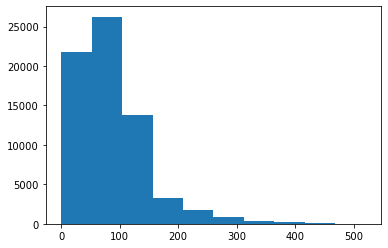

In [5]:
plt.hist(taxis_clipped['dist_to_nn_pickup'])

(array([17268., 23225., 14675.,  5718.,  3927.,  1740.,   991.,   476.,
          288.,    83.]),
 array([2.18871379e-01, 5.25941896e+01, 1.04969508e+02, 1.57344826e+02,
        2.09720144e+02, 2.62095462e+02, 3.14470781e+02, 3.66846099e+02,
        4.19221417e+02, 4.71596735e+02, 5.23972054e+02]),
 <a list of 10 Patch objects>)

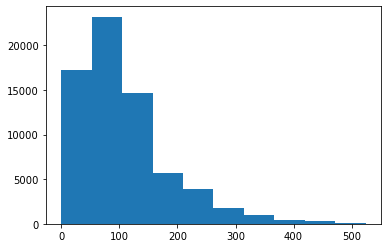

In [6]:
plt.hist(taxis_clipped['dist_to_nn_dropoff'])

In [7]:
lion_clipped['nodeidfrom'] = lion_clipped['nodeidfrom'].astype(int)
lion_clipped['nodeidto'] = lion_clipped['nodeidto'].astype(int)

# REVIST THIS: SHOULD DUPLICATES BE DROPPED?  LOOK AT SEGCOUNT IN MAP
# IF THERE ARE DUPLICATES, SELECT WHERE RW_IS NOT ZERO

#lion_filt = lion_clipped.drop_duplicates(subset=['nodeidfrom','nodeidto','nodelevelf','nodelevelt'], keep='first', inplace=False).reset_index()
#lion_filt['seg_id'] = np.arange(lion_filt.shape[0])
#lion_filt.set_index(['node_low','node_high'], inplace = True)

In [8]:
#lion_filt[lion_filt['rw_type'] == 6]
#list(lion_clipped.columns)
#n = (lion_filt['rw_type'] == 6).to_numpy()
#lion_filt.iloc[n]
#lion_clipped.dtypes #[lion_clipped['rw_type'] == 6]

lion_clipped['feature_filt'] = lion_clipped.apply(lambda x : (x['featuretyp'].strip() == '0') # street
                                            and ((x['rw_type'].strip() == '1') # street
                                                 or (x['rw_type'].strip() == '2') # highway
                                                 or (x['rw_type'].strip() == '3') # bridge
                                                 or (x['rw_type'].strip() == '4') # tunnel
                                                 or (x['rw_type'].strip() == '9')) # ramp
                                            and (x['segmenttyp'] != 'G') # generic
                                            and (x['segmenttyp'] != 'F') # faux
                                            and (x['trafdir'] != 'P') # pedestrian 
                                                  ,axis = 1) 

<ipython-input-9-0a273b673bc5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lion_filt.drop_duplicates(subset=['nodeidfrom','nodeidto','nodelevelf','nodelevelt'],


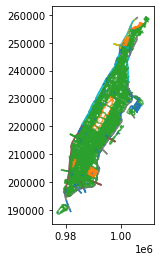

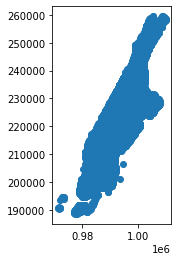

In [9]:
lion_filt = lion_clipped[lion_clipped['feature_filt']]
lion_filt.drop_duplicates(subset=['nodeidfrom','nodeidto','nodelevelf','nodelevelt'],
                          keep='first', inplace = True)
lion_filt.reset_index(inplace = True)
lion_filt.plot(column='posted_speed')
nodes_clipped.plot()

for each node, find all segments with the same nodeto
for each of those segments, find nodelevelt
if not all nodelevelt are equal, delete this node

find all segments with node from this node
get the node to of these segments
create edge with weight of seg_length of both roads

In [10]:
nodes_clipped

,objectid,nodeid,vintersect,shape
0,11544,12242,,POINT (977028.605 188715.487)
1,11546,12244,,POINT (977720.798 188478.034)
2,11547,12245,,POINT (977302.692 189687.615)
3,11548,12246,,POINT (977563.185 189326.973)
4,11549,12247,,POINT (977599.818 189396.812)
...,...,...,...,...
15422,132590,9054617,,POINT (1000753.672 241714.669)
15423,132591,9054618,,POINT (1000782.785 241767.131)
15424,132592,9054619,,POINT (1000792.767 241763.215)
15425,132593,9054620,,POINT (1000762.379 241710.028)


In [11]:
nodes_clipped['nodeid'] = nodes_clipped['nodeid'].astype(int)
#nodes_clipped.set_index('nodeid', inplace = True)
print(nodes_clipped['nodeid'].max())
node_new = nodes_clipped['nodeid'].max() + 1

9054620


In [12]:
lion_index = lion_filt.index

for i in nodes_clipped.index:
    cur_id = nodes_clipped.loc[i,'nodeid']
    segs_to = lion_filt.loc[lion_filt['nodeidto'] == cur_id,:]
    levels = segs_to['nodelevelt'].unique()
    if len(levels) > 1:
        for l in levels:
            locs_to = (lion_filt['nodeidto'] == cur_id) & (lion_filt['nodelevelt'] == l)
            lion_filt.loc[locs_to, 'nodeidto'] = node_new
            
            locs_from = (lion_filt['nodeidfrom'] == cur_id) & (lion_filt['nodelevelf'] == l)
            lion_filt.loc[locs_from, 'nodeidfrom'] = node_new
            
            node_new = node_new + 1

C:\Users\comp\anaconda3\envs\geopandas_env\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [13]:
lion_filt['node_low'] = lion_filt.apply(lambda x : min(x['nodeidto'], x['nodeidfrom']), axis = 1)
lion_filt['node_high'] = lion_filt.apply(lambda x : max(x['nodeidto'], x['nodeidfrom']), axis = 1)

<ipython-input-13-3ffca3cc4ae3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lion_filt['node_low'] = lion_filt.apply(lambda x : min(x['nodeidto'], x['nodeidfrom']), axis = 1)
<ipython-input-13-3ffca3cc4ae3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lion_filt['node_high'] = lion_filt.apply(lambda x : max(x['nodeidto'], x['nodeidfrom']), axis = 1)


In [14]:
# lion_filt = lion_filt[(lion_filt['nodeidto'] != -1) & (lion_filt['nodeidfrom'] != -1)]
# lion_filt.plot()

In [15]:
# lion_filt['velocity'] = 0
# lion_filt['seg_id'] = np.arange(lion_filt.shape[0])
# lion_filt['shape_wkt'] = lion_filt['shape'].apply(lambda x : WKTElement(x,srid=2263))
# lion_filt[['seg_id','shape_wkt','velocity','nodeidto','nodeidfrom']].to_sql('lion_velocity', engine, if_exists='replace', index=False,
#                                        dtype={'shape_wkt': Geometry('MULTILINESTRING', srid= 2263)})

In [16]:
def getDGedges(row):
    if row['trafdir'] == 'T':
        return [(row['nodeidfrom'],row['nodeidto'], {'weight' : row['shape_length']}), (row['nodeidto'],row['nodeidfrom'], {'weight' : row['shape_length']})]
    elif row['trafdir'] == 'W':
        return [(row['nodeidfrom'],row['nodeidto'], {'weight' : row['shape_length']})]
    elif row['trafdir'] == 'A':
        return [(row['nodeidto'],row['nodeidfrom'], {'weight' : row['shape_length']})]
    else:
        print(row['trafdir'])
        raise Exception('TRAFDIR DID NOT PROCESS')

lion_filt['DG_node'] = lion_filt.apply(lambda x : getDGedges(x), axis = 1)
lion_filt.set_index(['node_low','node_high'], inplace = True)
#lion_filt.index.is_lexsorted()  TALK ABOUT IN REPORT
lion_filt.sort_index(inplace = True)
lion_filt['seg_id'] = np.arange(lion_filt.shape[0])


<ipython-input-16-ae378b3ad550>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lion_filt['DG_node'] = lion_filt.apply(lambda x : getDGedges(x), axis = 1)
<ipython-input-16-ae378b3ad550>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lion_filt.sort_index(inplace = True)
<ipython-input-16-ae378b3ad550>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [17]:
#lion_filt.loc[(20868,9052926),:]

In [18]:
to_unique = lion_filt['nodeidto'].unique()
from_unique = lion_filt['nodeidto'].unique()
all_unique = np.concatenate((to_unique, from_unique))
unique_only = np.unique(all_unique)

In [19]:
print(len(to_unique))
print(len(from_unique))
print(len(all_unique))
print(len(unique_only))
print(unique_only.max())

12544
12544
25088
12544
9055888


In [20]:
G = nx.DiGraph()
G.add_nodes_from(all_unique)
for i,row in lion_filt.iterrows():
    G.add_edges_from(row['DG_node'])

In [21]:
t2 = time.time()
paths_ss = nx.single_source_dijkstra(G, 22516, weight='weight')
t3 = time.time()

t5 = t3 - t2
t5

0.07180643081665039

In [22]:
#len(paths_ss[1])

In [28]:
lion_filt.loc[:,'path_count'] = 0
for ti,trow in taxis_clipped.iterrows():
    inode = trow['nn_pickup']
    jnode = trow['nn_dropoff']
    
    if inode != jnode:
        try:
            p = nx.dijkstra_path(G, inode, jnode, weight = 'weight')
            path_int = [int(pp) for pp in p]

            for i in np.arange(1,len(p)):
                nodes_temp = [p[i], p[i-1]]
                node_min = min(nodes_temp)
                node_max = max(nodes_temp)
                row = lion_filt.loc[(node_min,node_max)]
                lion_filt.loc[(node_min,node_max),'path_count'] = row['path_count'] + 1
        except:
            pass

C:\Users\comp\anaconda3\envs\geopandas_env\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


In [25]:
# CAREFUL NOT TO OVERWRITE THE DATABASE
# if(engine.has_table('paths')):
#     engine.execute('DROP TABLE paths')
    
# lion_filt.loc[:,'path_count'] = 0

# t0 = time.time()
# n = 0
# path_arr = []
# for ti,trow in taxis_clipped.iterrows():
#     inode = trow['nn_pickup']
#     jnode = trow['nn_dropoff']
    
#     if inode != jnode:
#         try:
#             p = nx.dijkstra_path(G, inode, jnode, weight = 'weight')
#             path_int = [int(pp) for pp in p]

#             p_seg_ids = []
#             p_seg_lengths = []
#             p_seg_shapes = []
#             p_rw_types = []
#             for i in np.arange(1,len(p)):
#                 nodes_temp = [p[i], p[i-1]]
#                 node_min = min(nodes_temp)
#                 node_max = max(nodes_temp)
#                 row = lion_filt.loc[(node_min,node_max)]
#                 lion_filt.loc[(node_min,node_max),'path_count'] = row['path_count'] + 1
#                 p_seg_ids.append(int(row['seg_id']))
#                 p_seg_lengths.append(float(row['shape_length']))
#                 p_rw_types.append(int(row['rw_type'][0].strip()))
#                 for shape in row['shape']:
#                     p_seg_shapes.append(shape[0])

#             path_arr.append({'nodeidfrom' : int(inode),
#                             'nodeidto' : int(jnode),
#                             'nodes' : path_int,
#                             'seg_ids' : p_seg_ids,
#                             'seg_lengths' : p_seg_lengths,
#                             'seg_shapes' : WKTElement(MultiLineString(p_seg_shapes),srid=2263),
#                             'rw_types' : p_rw_types,
#                             'total_length' : np.array(p_seg_lengths).sum(),
#                             'rw_start' : p_rw_types[0],
#                             'rw_end' : p_rw_types[-1],
#                             'recorded_dist' : trow['trip_distance']*5280.,
#                             'travel_time' : trow['travel_time'],
#                             'dist_to_nn_dropoff' : trow['dist_to_nn_dropoff'],
#                             'dist_to_nn_pickup' : trow['dist_to_nn_pickup'],
#                             'pickup_longitude' : trow['pickup_longitude'],
#                             'pickup_latitude' : trow['pickup_latitude'],
#                             'dropoff_longitude' : trow['dropoff_longitude'],
#                             'dropoff_latitude' : trow['dropoff_latitude'],
#                             'avg_vel_mph' : trow['trip_distance'] / (trow['travel_time'] / 3600.)})

#         except:
#             path_arr.append({'nodeidfrom' : int(inode),
#                             'nodeidto' : int(jnode),
#                             'total_length' : -1})

#         n = n + 1
#         if n > 0 and n % 1000 == 0:
#             print("Writing row " + str(n))
#             path_df = pd.DataFrame(path_arr)
#             path_df.to_sql('paths', engine, if_exists = 'append',
#                             dtype = {'nodes' : ARRAY(INTEGER), 
#                                  'seg_ids' : ARRAY(INTEGER),
#                                  'seg_lengths' : ARRAY(DOUBLE_PRECISION),
#                                  'seg_shapes' : Geometry('MULTILINESTRING', srid=2263),
#                                 'rw_types' : ARRAY(INTEGER)})
#             path_arr = []
# if path_arr != []:
#         path_df = pd.DataFrame(path_arr)
#         path_df.to_sql('paths', engine, if_exists = 'append',
#                         dtype = {'nodes' : ARRAY(INTEGER), 
#                              'seg_ids' : ARRAY(INTEGER),
#                              'seg_lengths' : ARRAY(DOUBLE_PRECISION),
#                              'seg_shapes' : Geometry('MULTILINESTRING', srid=2263),
#                             'rw_types' : ARRAY(INTEGER)})
# t1 = time.time()

SyntaxError: unexpected EOF while parsing (<ipython-input-25-661e3902a220>, line 79)

In [24]:
# for 100000 rows: *68000 rows
# with sql 744 seconds
# without sql 688 seconds
# paths along is about 105 seconds
# for 1000 rows;
# all: 61, path only: 10, path + seg lookup: 33
total = t1-t0
total

NameError: name 't1' is not defined

In [25]:
taxi_filt_query = '''SELECT seg_ids, travel_time, seg_lengths
FROM paths
WHERE total_length != -1
AND avg_vel_mph > 2
AND avg_vel_mph < 60
AND dist_to_nn_dropoff < 400
AND dist_to_nn_pickup < 400
AND total_length < 100000
AND total_length > 2500
AND rw_start = 1
AND rw_end = 1
AND ABS(total_length - recorded_dist) < 2500
'''

taxis_filt = pd.read_sql(taxi_filt_query, engine)

In [26]:
taxis_filt

,seg_ids,travel_time,seg_lengths
0,"[10245, 10523, 10524, 7644, 7643, 10573, 14076...",343.0,"[281.418297134988, 260.959106910336, 262.25045..."
1,"[4696, 4694, 4677, 4673, 4670, 4668, 4537, 453...",1320.0,"[282.116759490183, 260.891594464961, 259.78584..."
2,"[1435, 1443, 1446, 1685, 1687, 1656, 1653, 165...",402.0,"[196.947217882161, 95.89677258553, 445.8019980..."
3,"[3259, 3262, 3261, 3263, 3265, 3274, 3383, 338...",465.0,"[145.230221390764, 112.091128317949, 257.42461..."
4,"[5185, 5191, 5184, 5182, 9486, 11602, 9621, 96...",588.0,"[93.895075522587, 200.01249011225, 79.57922911..."
...,...,...,...
55217,"[2936, 2943, 2933, 2935, 15731, 2932, 2929, 29...",672.0,"[900.351135864165, 277.269093640231, 258.32407..."
55218,"[5822, 5820, 5819, 5818, 5105, 5061, 5059, 505...",897.0,"[284.498009571904, 264.080176241954, 263.93190..."
55219,"[3226, 3227, 3320, 3322, 15559, 3336, 3334, 33...",899.0,"[259.779971983975, 680.342910983025, 220.31876..."
55220,"[5760, 10652, 10653, 10803, 10540, 10539, 1028...",236.0,"[33.8703465908241, 265.153146162782, 264.46586..."


In [ ]:
# bins = np.arange(0,3.4,0.2)
# labels = bins[0:-1] + 0.1

# taxis_clipped['dbin'] = pd.cut(taxis_clipped['trip_distance'], bins=bins, labels = labels)
# lower = taxis_clipped.groupby('dbin')['travel_time'].quantile(0.05)
# upper = taxis_clipped.groupby('dbin')['travel_time'].quantile(0.95)
# lower_arr = pd.DataFrame(lower).reset_index().to_numpy()
# upper_arr = pd.DataFrame(upper).reset_index().to_numpy()


# from scipy.interpolate import UnivariateSpline
# spl_lower = UnivariateSpline(lower_arr[:,0],lower_arr[:,1])
# spl_upper = UnivariateSpline(upper_arr[:,0],upper_arr[:,1])

# taxis_clipped['trip_time_p5'] = taxis_clipped['trip_distance'].apply(lambda x : float(spl_lower(x)))
# taxis_clipped['trip_time_p95'] = taxis_clipped['trip_distance'].apply(lambda x : float(spl_upper(x)))

In [ ]:
# taxis_clipped['filt'] = taxis_clipped.apply(lambda x : 
#                                             (x['trip_distance'] >= 0.5) 
#                                             and (x['trip_distance'] <= 2) 
#                                             and (x['travel_time'] >= x['trip_time_p5']) 
#                                             and (x['travel_time'] <= x['trip_time_p95']) 
#                                             and (x['dist_error'] < 0.2)
#                                             and (x['path_distance_mi'] != -1)
#                                             and (x['dist_to_nn_dropoff'] < 400)
#                                             and (x['dist_to_nn_pickup'] < 400)
#                                             and (x['rw_types'][0].strip() == '1')
#                                             and (x['rw_types'][-1].strip() == '1'), axis = 1)

# taxis_filt = taxis_clipped[taxis_clipped['filt']].reset_index()

In [ ]:
# plt.scatter(taxis_filt['total_length'],taxis_filt['travel_time'], alpha = 0.1)

In [ ]:
# plt.scatter(taxis_filt['recorded_distance'],taxis_filt['total_length']/5280, alpha = 0.1)

In [27]:
#lion_filt['posted_speed'].astype(int)#pow(-1)
#pd.to_numeric(lion_filt['posted_speed'])
#lion_filt.drop(columns = ['shape_wkt'], inplace = True)

lion_filt.replace(to_replace = '  ', value = {'posted_speed' : '50'}, inplace = True)
lion_filt['vel_ub'] = lion_filt['posted_speed'].astype(float).pow(-1).multiply(3600/5280).multiply(1.2)

C:\Users\comp\anaconda3\envs\geopandas_env\lib\site-packages\pandas\core\frame.py:4166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-27-f16cb63c163b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lion_filt['vel_ub'] = lion_filt['posted_speed'].astype(float).pow(-1).multiply(3600/5280).multiply(1.2)


In [30]:
taxis_filt.to_csv('taxis_filt.csv')
lion_filt['vel_ub'].to_csv('lion_filt.csv')

In [28]:
trip_filt_idx = taxis_filt.index
num_segments = lion_filt.shape[0]
A = np.zeros([len(trip_filt_idx), num_segments])

for i in trip_filt_idx:
    seg_coefs = np.zeros(num_segments)
    seg_coefs[taxis_filt.loc[i,'seg_ids']] = taxis_filt.loc[i,'seg_lengths']
    A[i] = seg_coefs

In [ ]:
b = taxis_filt['travel_time'] 
lb = lion_filt['vel_ub'] # 85 mph
ub = np.ones(num_segments)*0.7 # 1 mph

x = lsq_linear(A, b, bounds = (lb, ub), verbose = 2, max_iter = 100)

In [40]:
x

 active_mask: array([0, 0, 0, ..., 0, 0, 0])
        cost: 99484342.91569209
         fun: array([ 22.68417253, -24.79711406,  73.26808243, ...,  51.41882788,
       108.85508824,  55.36555744])
     message: 'The maximum number of iterations is exceeded.'
         nit: 100
  optimality: 58728.41996927385
      status: 0
     success: False
           x: array([0.03424698, 0.11636364, 0.08469496, ..., 0.04572889, 0.03279213,
       0.03282523])

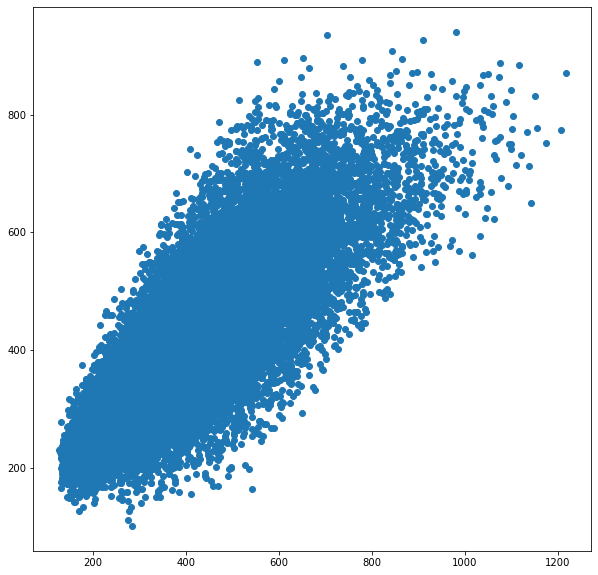

In [41]:
pred = np.matmul(A, x['x'])

plt.figure(figsize=(10,10))
plt.scatter(b, pred)

(array([142.,  64.,  42.,  37.,  50.,  35.,  44.,  45.,  51.,  33.,  62.,
         60.,  44.,  28.,  37.,  35.,  26.,  33.,  25.,  24.,  26.,  19.,
         16.,  22.,  14.,  13.,  13.,  15.,  14.,   5.,  15.,  12.,   9.,
         20.,  19.,  11.,  32.,  25.,  51.,  11.,  16.,  14.,  14.,  29.,
         30.,  45.,  83., 138., 289.,  27.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   3.,   1.,   0.,   0.,   2.,   1.,   4.,
          1.]),
 array([ 0.97402597,  1.37888586,  1.78374575,  2.18860563,  2.59346552,
         2.9983254 ,  3.40318529,  3.80804518,  4.21290506,  4.61776495,
         5.02262484,  5.42748472,  5.83234461,  6.23720449,  6.64206438,
         7.04692427,  7.45178415,  7.85664404,  8.26150392,  8.66636381,
         9.0712237 ,  9.47

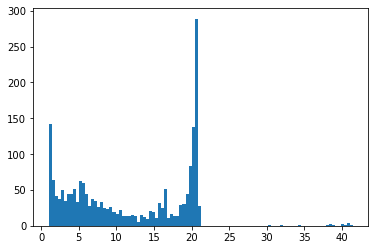

In [42]:
plt.hist((1/x['x'])*(1/5280)*3600, bins = 100)

In [29]:
# lion_filt['velocity'] = (1/x['x'])*(1/5280)*3600
lion_filt['shape_wkt'] = lion_filt['shape'].apply(lambda x : WKTElement(x,srid=2263))

<ipython-input-29-93b28eba6b17>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lion_filt['shape_wkt'] = lion_filt['shape'].apply(lambda x : WKTElement(x,srid=2263))


In [30]:
lion_filt[['seg_id','shape_wkt','path_count','nodeidfrom','nodeidto']].to_sql('lion_count', engine, if_exists='replace', index=False,
                                       dtype={'shape_wkt': Geometry('MULTILINESTRING', srid= 2263)})

In [40]:
lion_filt[lion_filt['path_count'] > 20].shape

(7393, 125)

In [33]:
lion_filt.shape

(16318, 125)

In [37]:
lf2 = lion_filt.drop(columns="shape_wkt")

In [39]:
lf2.head(100)

index  objectid             street  \
node_low node_high                                       
12242    106980       812     88161   CRAIG ROAD SOUTH   
         9053797    26614    113940       GRESHAM ROAD   
         9053804    26624    113950   CRAIG ROAD NORTH   
12245    9053620    26559    113885   CRAIG ROAD NORTH   
         9053803    26619    113945   CRAIG ROAD NORTH   
12246    9053798     9968     97315       GRESHAM ROAD   
12249    12256       4395     91738     HALF MOON ROAD   
         12258       9952     97299       ENRIGHT ROAD   
12256    12257       8192     95540   CRAIG ROAD SOUTH   
         64135       4557     91900   CRAIG ROAD SOUTH   
12257    12258        809     88158        YEATON ROAD   
         12260      13645    100994   CRAIG ROAD SOUTH   
12258    12259      26563    113889       ENRIGHT ROAD   
12259    12260      11786     99137        ICARUS ROAD   
         9046856    23460    110799       ENRIGHT ROAD   
         9053628    26562    113888       ENRIGHT ROAD   
12260    12289       2617     89959   CRAIG ROAD SOUTH   
12286    12341       2548     89890      DIVISION ROAD   
         12345      13536    100885        KING AVENUE   
         9046472    23451    110781      DIVISION ROAD   
12287    12288      11741     99092      DIVISION ROAD   
         12346       6204     93553        OWASCO ROAD   
         9046472    23443    110780      DIVISION ROAD   
12288    12289        740     88089      DIVISION ROAD   
         12291        714     88063      CARTIGAN ROAD   
12289    12292      13643    100992   CRAIG ROAD SOUTH   
12291    12292        816     88165       CLAYTON ROAD   
         12346       2621     89963       CLAYTON ROAD   
12292    63587       9885     97232        KIMMEL ROAD   
12293    14339       9887     97234       COMFORT ROAD   
         63586      13823    101173       COMFORT ROAD   
12313    12314        826     88175   CRAIG ROAD NORTH   
         9047051    23507    110839   CRAIG ROAD NORTH   
12314    12316       8194     95542   CRAIG ROAD NORTH   
12316    12319       6312     93661   CRAIG ROAD NORTH   
12318    12319       9898     97244      DIVISION ROAD   
         12321       9897     97243      DIVISION ROAD   
         63251       4330     91674       SHORT AVENUE   
12319    12324       6316     93665   CRAIG ROAD NORTH   
12321    63250       6206     93555     WHEELER AVENUE   
         9047055     6236     93585      DIVISION ROAD   
12323    12327      13651    101000       CLAYTON ROAD   
         12328      11716     99067     WHEELER AVENUE   
         12342       9963     97310       CLAYTON ROAD   
         63250       8717     96065     WHEELER AVENUE   
12324    12325        817     88166       CLAYTON ROAD   
         63780      10161     97508   CRAIG ROAD NORTH   
12325    12327      13652    101001       CLAYTON ROAD   
         63251      14183    101533       SHORT AVENUE   
12327    12328        818     88167       CLAYTON ROAD   
12328    12331       2533     89875     WHEELER AVENUE   
12329    63781       4347     91691   CRAIG ROAD NORTH   
         68726       6231     93580        CARDER ROAD   
12331    12349       9875     97221           HAY ROAD   
         9046984    23490    110822     WHEELER AVENUE   
12332    12351       6215     93564           HAY ROAD   
         12354       8116     95464         ANDES ROAD   
         68726       1325     88668           HAY ROAD   
12341    104507      9019     96367       ENRIGHT ROAD   
         9046857    23473    110803      DIVISION ROAD   
12342    12343        716     88065     EARLYBIRD ROAD   
         12344       6308     93657       CLAYTON ROAD   
         9050379    23452    110782     EARLYBIRD ROAD   
12343    12344       9880     97226           HAY ROAD   
         12349       6228     93577           HAY ROAD   
12344    12345      13650    100999       CLAYTON ROAD   
12345    12346       4405     91748       CLAYTON ROAD   
         12348    